In [1]:
from IPython.display import Image 
from IPython.display import display
from skimage import io
import sys
import os
os.chdir("/home/dev/software/fast-rcnn/tools/")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [26]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from utils.timer import Timer
from utils.cython_nms import nms
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
import dlib

In [4]:
CLASSES = ('__background__','n02958343','n02769748')
NETS = {'vgg16': ('VGG16',
                  'vgg16_fast_rcnn_iter_40000.caffemodel'),
        'vgg_cnn_m_1024': ('VGG_CNN_M_1024',
                           'vgg_cnn_m_1024_fast_rcnn_iter_40000.caffemodel'),
        'caffenet': ('CaffeNet',
                     'caffenet_fast_rcnn_iter_40000.caffemodel')}

In [86]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        print 'inds 0 ?'
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.savefig("test.png")
    display(Image(filename='test.png',width=400, height=400))

def run_dlib_selective_search(image_name):
    if 'http://' in image_name:
        img = io.imread(image_name)
    else:
        img = io.imread(image_name)
    rects = []
    dlib.find_candidate_object_locations(img,rects,min_size=50)
    proposals = []
    for k,d in enumerate(rects):
        templist = [d.left(),d.top(),d.right(),d.bottom()]
        proposals.append(templist)
    proposals = np.array(proposals)
    return proposals

In [70]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""
    
    # Load the demo image
    if 'http://' in image_name:
        im = io.imread(image_name)
        im_file = image_name
        
    else:
        im_file = os.path.join(cfg.DATA_DIR, image_name)
        im = cv2.imread(im_file)
        
    # Load pre-computed Selected Search object proposals
#     im_file = os.path.join(cfg.ROOT_DIR, 'data', 'demo', image_name + '.jpg')
    obj_proposals = run_dlib_selective_search(im_file)


    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im, obj_proposals)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        cls_boxes = cls_boxes[keep, :]
        cls_scores = cls_scores[keep]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        print 'All {} detections with p({} | box) >= {:.1f}'.format(cls, cls,
                                                                    CONF_THRESH)
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [7]:
prototxt = '/home/dev/software/fast-rcnn/models/VGG16/test.prototxt'
caffemodel = '/home/dev/software/fast-rcnn/data/fast_rcnn_models/vgg16_fast_rcnn_iter_40000.caffemodel'
caffe.set_mode_gpu()
caffe.set_device(6)
cfg.GPU_ID = 6

print prototxt
print caffemodel
net = caffe.Net(prototxt, caffemodel, caffe.TEST)
print '\n\nLoaded network {:s}'.format(caffemodel)


/home/dev/software/fast-rcnn/models/VGG16/test.prototxt
/home/dev/software/fast-rcnn/data/fast_rcnn_models/vgg16_fast_rcnn_iter_40000.caffemodel


Loaded network /home/dev/software/fast-rcnn/data/fast_rcnn_models/vgg16_fast_rcnn_iter_40000.caffemodel


In [ ]:
http://image.gsshop.com/image/10/56/10567540_L1.jpg

In [37]:
def select_dir(dir_name):
    cfg.DATA_DIR = os.path.join(PATH_DIR, dir_name)

In [36]:
PATH_DIR = '/home/dev/jude/data/ILSVRC2015_DET_sample/data/Images/ILSVRC2013_train/'

In [91]:
select_dir('n02958343')

Detection took 0.427s for 4350 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8


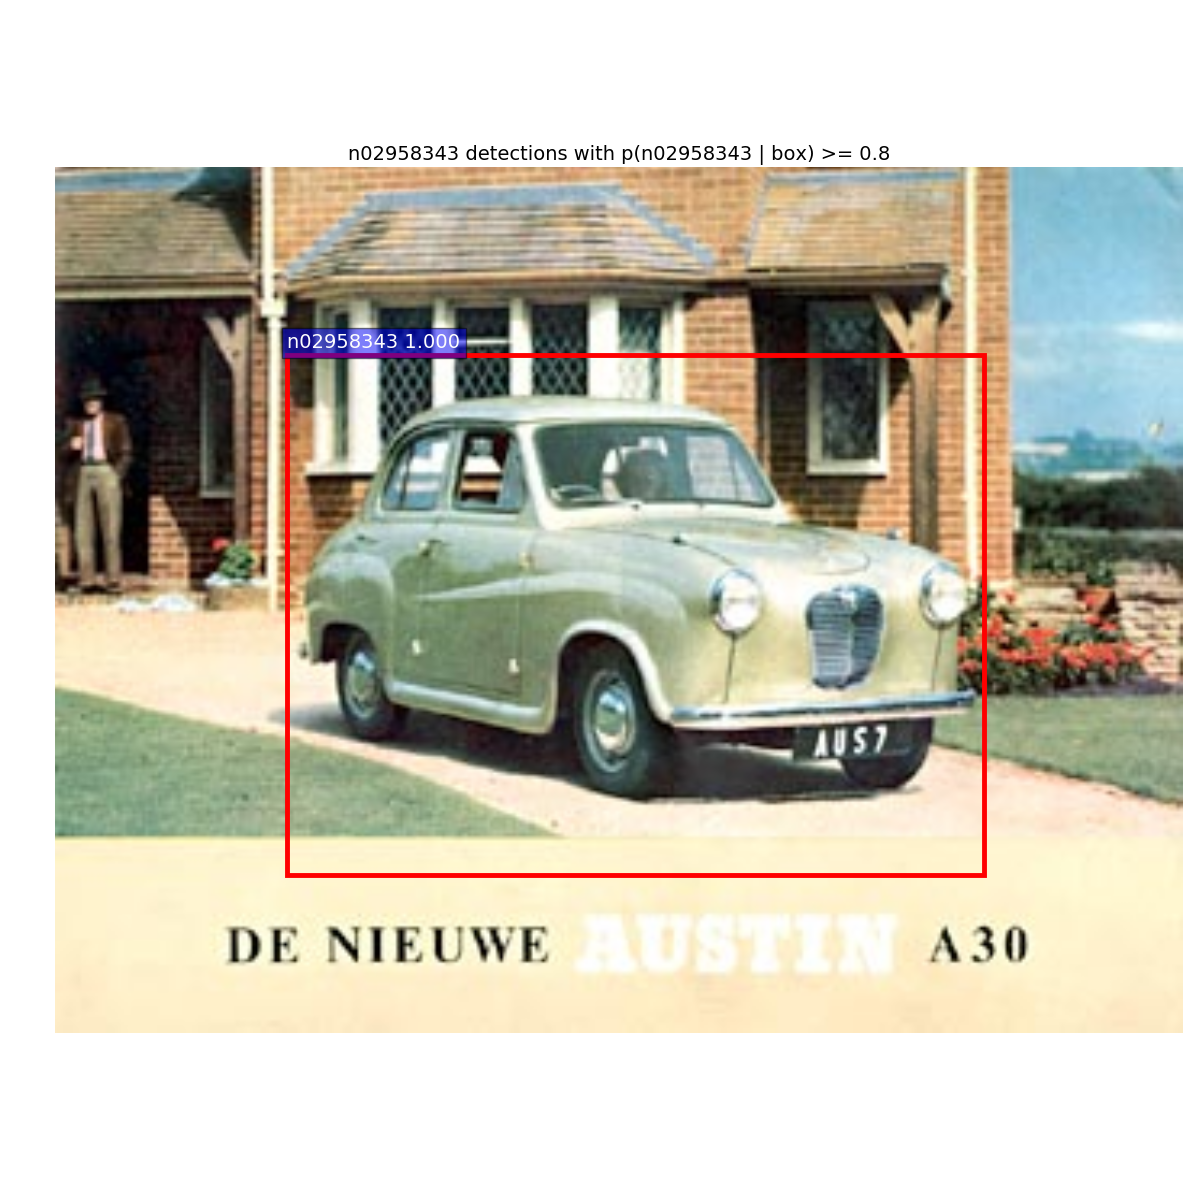

All n02769748 detections with p(n02769748 | box) >= 0.8
inds 0 ?


In [96]:
demo(net, 'n02958343_50699.JPEG')

Detection took 0.377s for 4194 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8


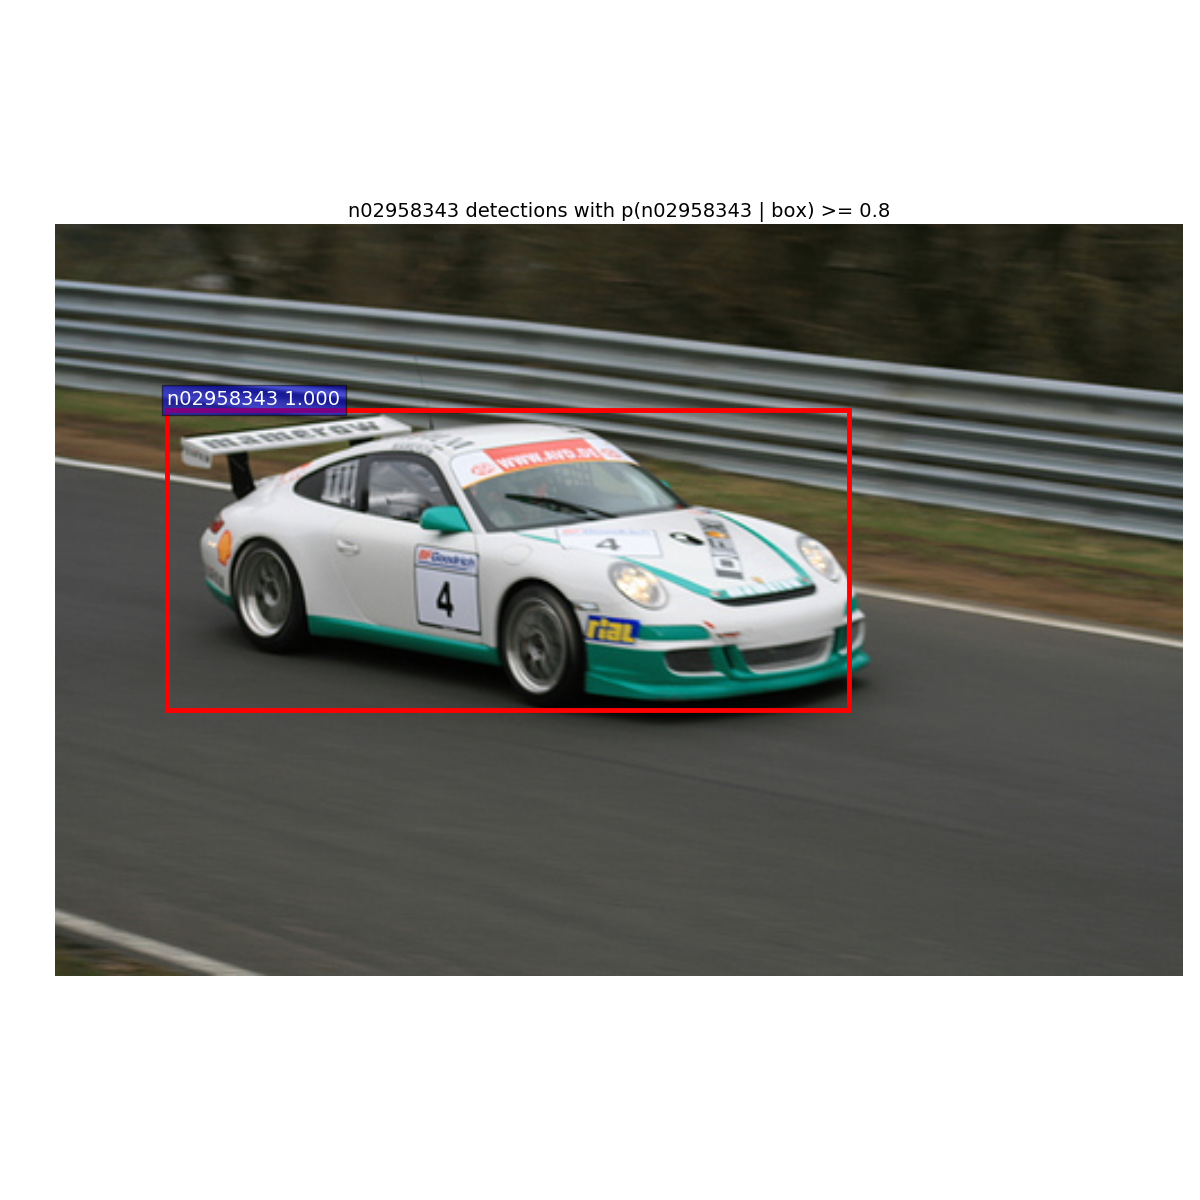

All n02769748 detections with p(n02769748 | box) >= 0.8
inds 0 ?


In [97]:
demo(net, 'n02958343_14698.JPEG')

In [98]:
demo(net, 'n02769748_28025.JPEG')

IOError: [Errno 2] No such file or directory: '/home/dev/jude/data/ILSVRC2015_DET_sample/data/Images/ILSVRC2013_train/n02958343/n02769748_28025.JPEG'

Detection took 0.783s for 11409 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8
inds 0 ?
All n02769748 detections with p(n02769748 | box) >= 0.8


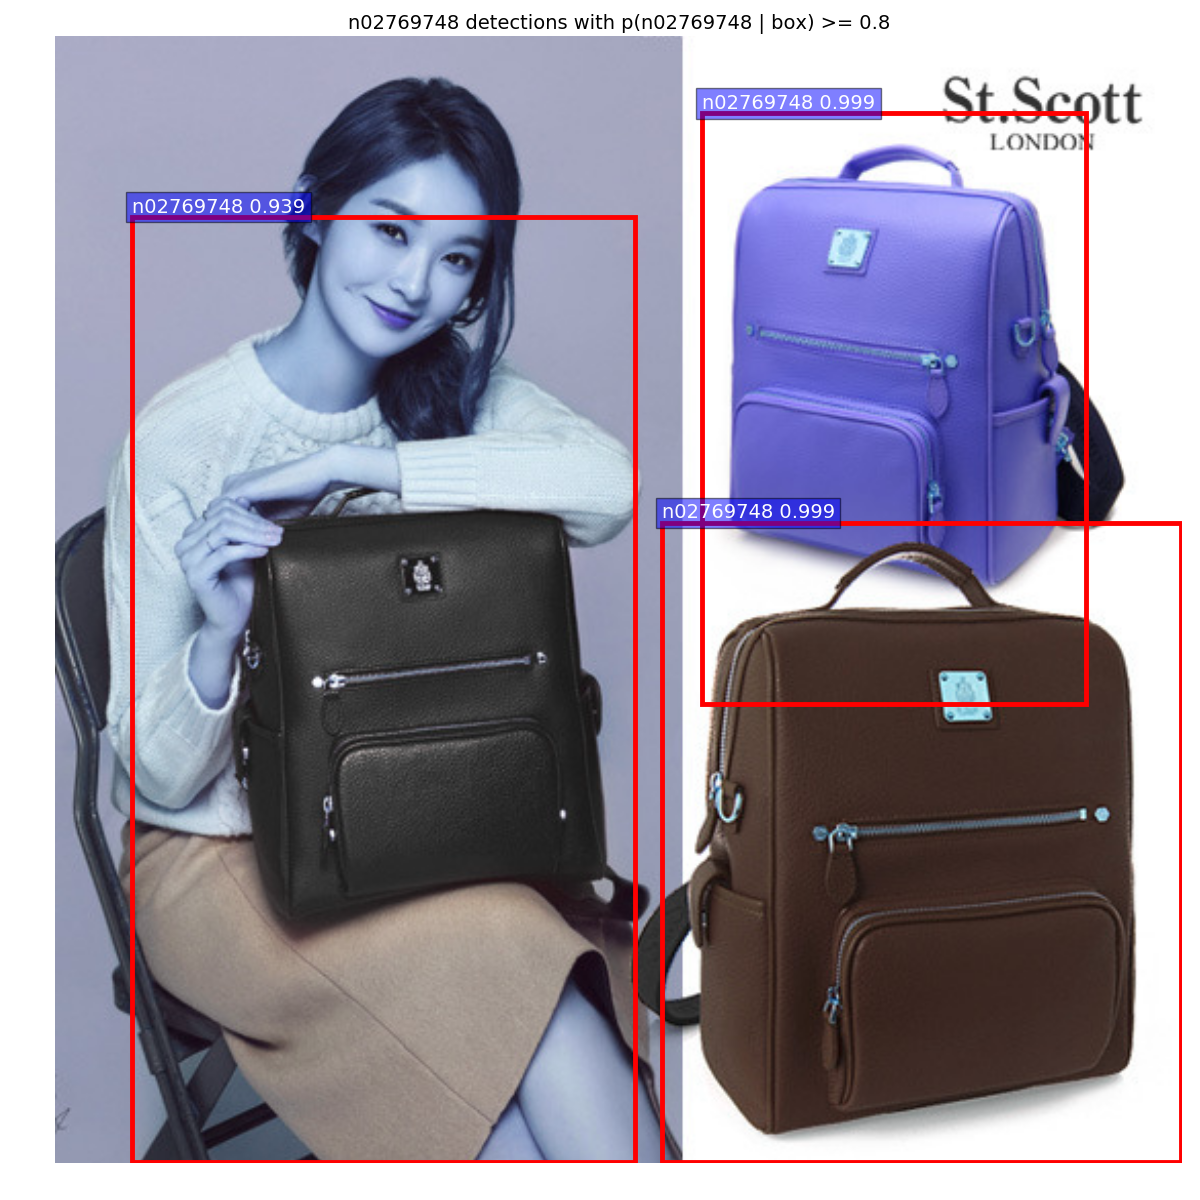

In [99]:
demo(net, 'http://image.gsshop.com/image/10/56/10567540_L1.jpg')

Detection took 0.405s for 4610 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8
inds 0 ?
All n02769748 detections with p(n02769748 | box) >= 0.8


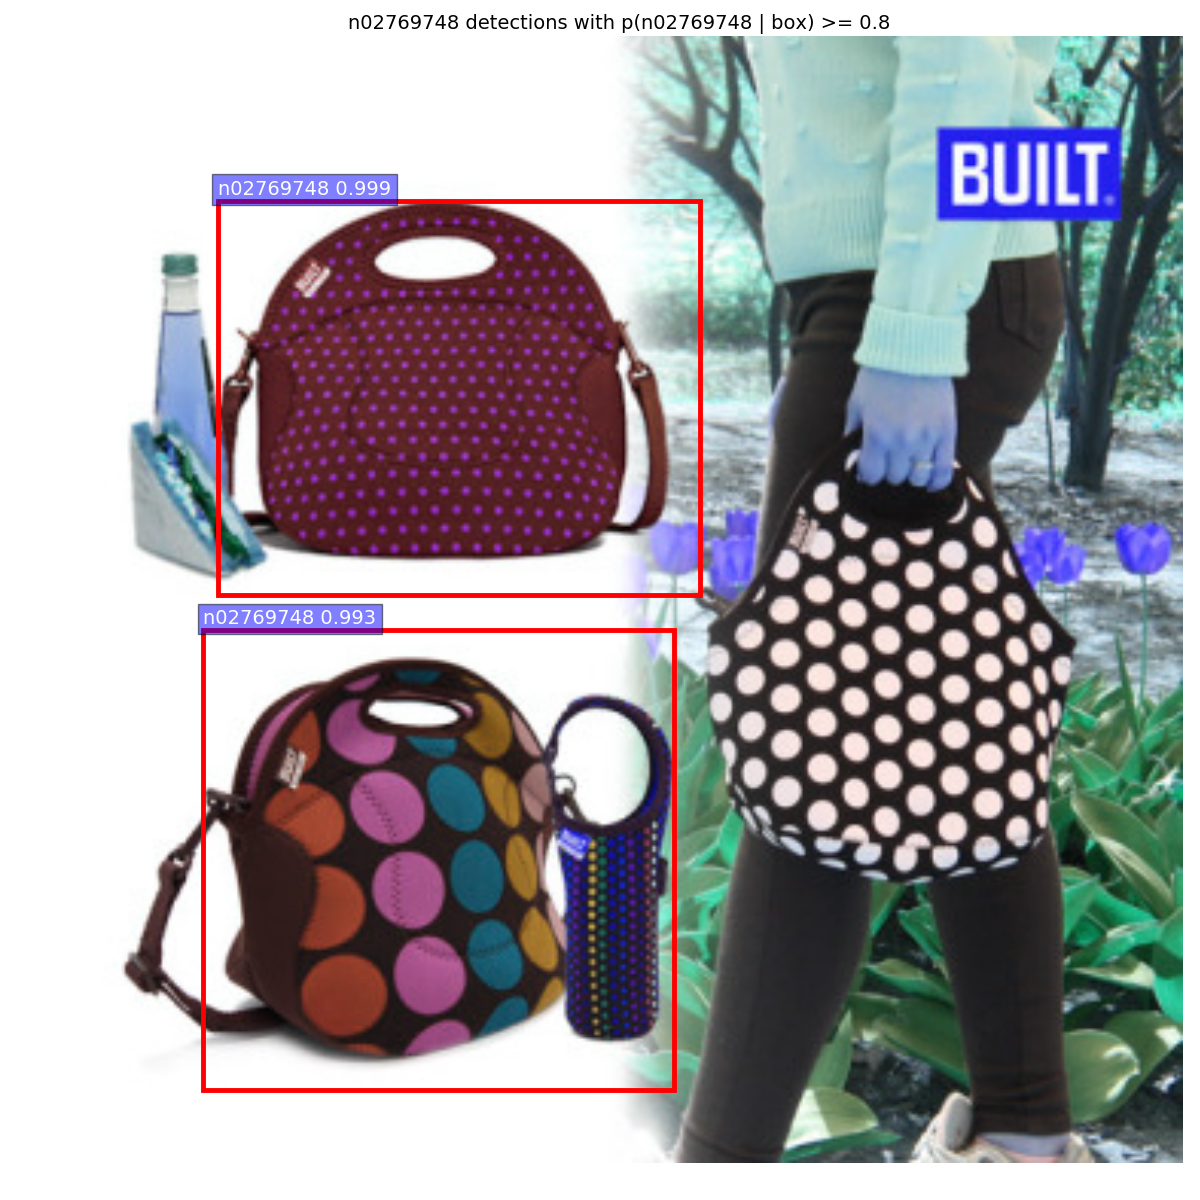

In [100]:
demo(net, 'http://image.gsshop.com/image/20/56/20560427_O1.jpg')

Detection took 0.209s for 2340 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8
inds 0 ?
All n02769748 detections with p(n02769748 | box) >= 0.8


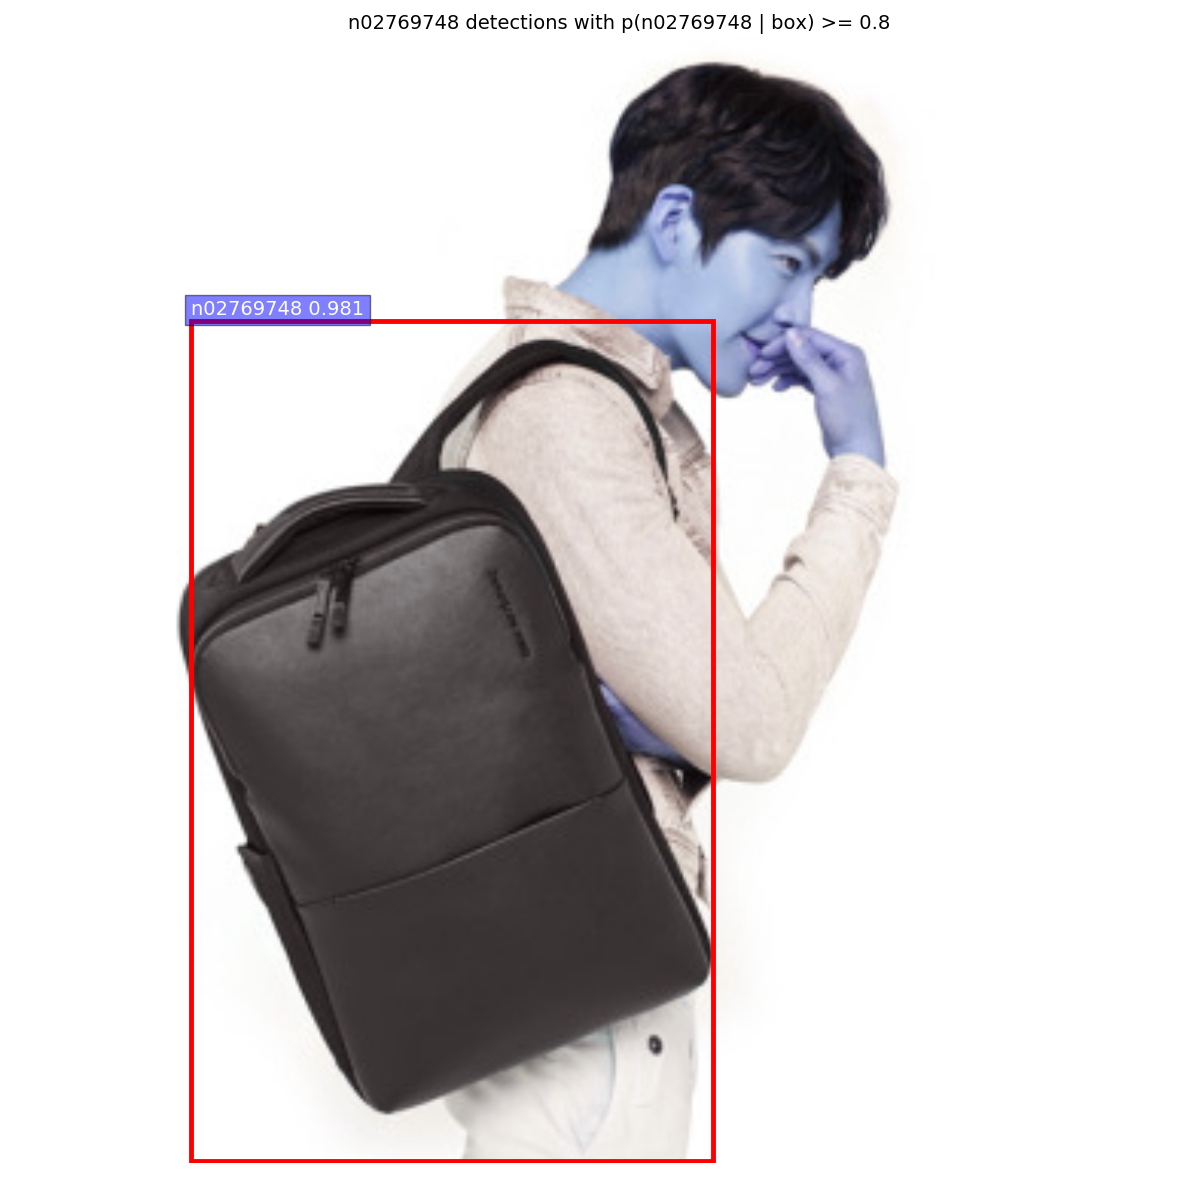

In [101]:
demo(net, 'http://image.gsshop.com/image/19/19/19190021_O1.jpg')

Detection took 0.421s for 4662 object proposals
All n02958343 detections with p(n02958343 | box) >= 0.8
inds 0 ?
All n02769748 detections with p(n02769748 | box) >= 0.8


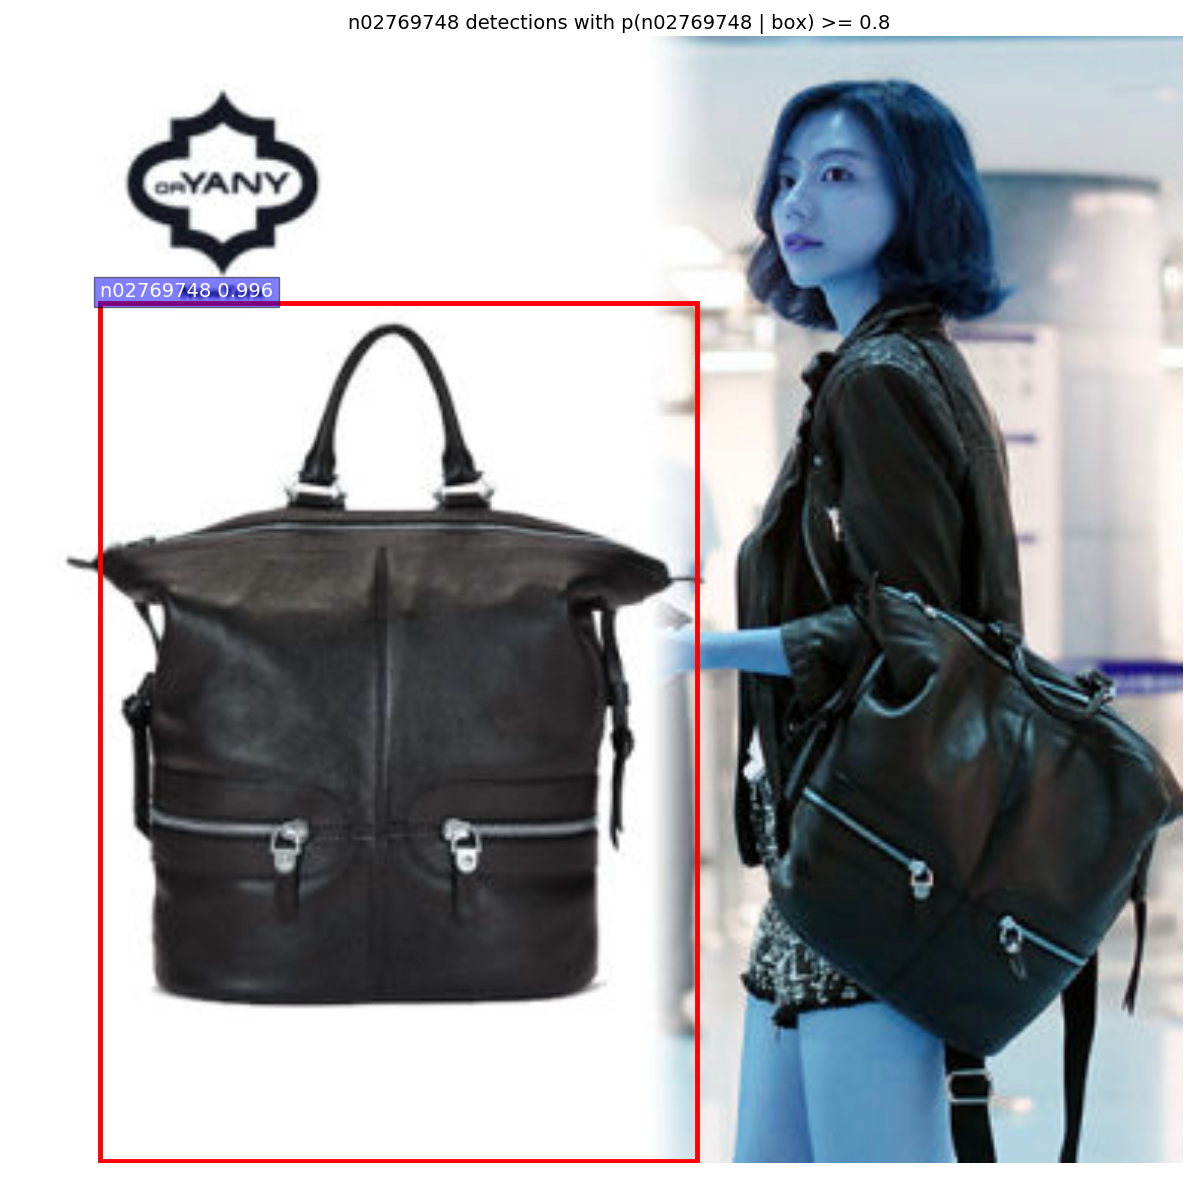

In [102]:
demo(net, 'http://image.gsshop.com/image/17/24/17245941_O1.jpg')

In [103]:
demo(net, 'IMG_1275.JPEG')

IOError: [Errno 2] No such file or directory: '/home/dev/jude/data/ILSVRC2015_DET_sample/data/Images/ILSVRC2013_train/n02958343/IMG_1275.JPEG'